In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

In [10]:
def heat_plot(
        traces,
        t=None,
        ax=None,
        colorbar=True,
        clim=[1, 5],
        cmap='magma',
        label='activity',
        time_label = 't'
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 5))
    if type(traces) == pd.core.frame.DataFrame:
        t = traces[time_label].values
        heatmap = traces[[
            col for col in traces.columns if col.startswith('c')]].values.T
    else:
        heatmap = traces
    extent = [t[0], t[-1], np.shape(heatmap)[0], 0]
    im = ax.imshow(
        heatmap,
        aspect='auto',
        extent=extent,
        clim=clim,
        cmap=cmap,
        interpolation='none'
    )
    if colorbar is True:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(
            "right",
            size="5%",
            pad=0.05,
            aspect=2.3 / 0.15
        )
        plt.colorbar(im, cax=cax, extendfrac=20, label=label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cell Number')

In [4]:
def slice_df(input_df, event_index, index_before, index_after):
    '''
    A convenience function for slicing a portion of a dataframe surrounding an event.
    This is a useful component for getting event triggered average responses for a given cell.

    Parameters
    ----------
    input_df : pandas.DataFrame
        the input dataframe to slice
    event_index : int
        the event index relative to which we are slicing
    index_before : int
        how many indices before each event to slice
    index_after : int
        how many indices after each event to slice

    Returns
    -------
    np.array
        values of the input_df ranging from event_index - index_before : event_index + index_after
    '''
    values = input_df.query('index >= {} and index < {}'.format(event_index - index_before, event_index + index_after))['y'].values
    if event_index - index_before < 0:
        # pad with nans if we overrun the start of the series
        values = np.hstack([np.zeros(np.abs(event_index - index_before))*np.nan, values])
    elif event_index + index_after > input_df['index'].max():
        # pad with nans if we overrun the end of the series
        values = np.hstack([values, np.zeros(np.abs(event_index + index_after - input_df['index'].max() - 1))*np.nan])

    return values


def event_triggered_response(input_df, source, events, index_before = 300, index_after = 300, n_cores=2):
    '''
    A function for extracting an event triggered response of a cell given some array of events.
    The function is parallelized using multiprocessing.Pool to speed calculation time
    Note: Google Colab instances only have 2 cores, so benefit from parellelizing will be minimal

    Parameters
    ----------
    input_df : pandas.DataFrame
        the input dataframe to slice
    source : string
        the cell ID of interest
    events : list of ints
        a list of event indices around which we want to calculate the response
    index_before : int
        how many indices before each event to slice (default = 300)
    index_after : int
        how many indices after each event to slice (default = 300)
    n_cores : int
        the number of cores across which to attempt to parallelize (default = 2)

    Returns
    -------
    Pandas.DataFrame
        a tidy dataframe with the following columns
            relative_indices (int) : the indices relative to the event index
            value (float) : the recorded value of the cell at each index
            event (int) : the index of the event
            event_number (int) : the integer ID assigned to the event
    '''
    this_cell_df = input_df.query('source == "{}"'.format(source))

    relative_indices = np.arange(-index_before, index_after)
    
    output_df_list = []
    for event_number, event in enumerate(events):
        values = slice_df(input_df, event, index_before, index_after)
        df = pd.DataFrame({
            'relative_indices': relative_indices, 
            'value': values,
            'event': (event*np.ones_like(values)).astype(int),
            'event_number': (event_number*np.ones_like(values)).astype(int),
        })
        output_df_list.append(df)

    # return the concatenated dataframes
    return pd.concat(output_df_list)

<IPython.core.display.Javascript object>


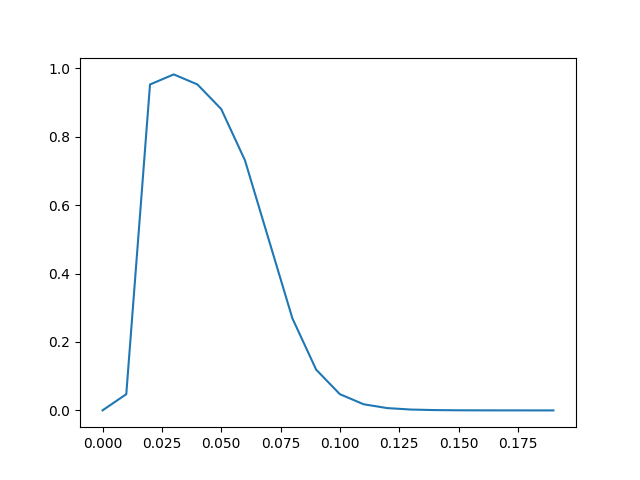

In [5]:
sampling_rate = 0.01
t = np.arange(0, 0.2, sampling_rate)
v1 = 1/(1 + np.exp(-600*(t - 0.015)))
v2 = 1/(1 + np.exp(100*(t - 0.07)))

fig,ax = plt.subplots()
kernel = pd.DataFrame({'t': t, 'v1': v1, 'v2': v2})
kernel['combined'] = kernel[['v1','v2']].min(axis = 1)

ax.plot(
    t,
    kernel['combined']
)

In [6]:
tf = 1000
ts = np.arange(0, tf, sampling_rate)

n_events = 100
np.random.seed(0)
event_times = np.sort(np.random.choice(ts, size=n_events, replace=False))
event_times = np.round(event_times, 1)
event_indices = [np.where(ts >= event_time)[0][0] for event_time in event_times]

random_event_times = np.sort(np.random.choice(ts, size=n_events*5, replace=False))
random_event_indices = [np.where(ts == event_time)[0][0] for event_time in random_event_times]

y_events = np.zeros_like(ts)
y_events[event_indices] = 1

reliability = 0.6
noise_std = 0.2
jitter = 0.01
spontaneous_rate = 1

cells = {
    'cell_0':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_1':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_2':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_3':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_4':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_5':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_6':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_7':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
    'cell_8':{
        'reliability': reliability,
        'jitter': jitter,
        'noise_std': noise_std,
        'spontaneous_rate': spontaneous_rate,
    },
}

In [7]:
all_activity = []
for cell in cells.keys():
    ys = cells[cell]['noise_std']*np.random.randn(len(ts))

    for event_time in np.random.choice(event_times, size=int(cells[cell]['reliability']*len(event_times)), replace=False):
        index = np.where(ts >= event_time + cells[cell]['jitter']*np.random.randn())[0][0]
        ys[index:index + len(kernel['t'])] += kernel['combined']
        
    probability = cells[cell]['spontaneous_rate']*sampling_rate
    spontaneous_activity = np.random.choice([0, 1], size=len(ts), p=[1-probability, probability])
    for spontaneous_event_index in np.where(spontaneous_activity==1)[0]:
        idx_max = np.min((spontaneous_event_index+len(kernel['combined']), len(ts)))
        ys[spontaneous_event_index:spontaneous_event_index + len(kernel['t'])] += kernel['combined'].iloc[:(idx_max-spontaneous_event_index)]

    tidy_data = pd.DataFrame({'t':ts, 'index': np.arange(len(ts)), 'y': ys})
    tidy_data['source'] = cell
    all_activity.append(tidy_data)
all_activity = pd.concat(all_activity)

<IPython.core.display.Javascript object>


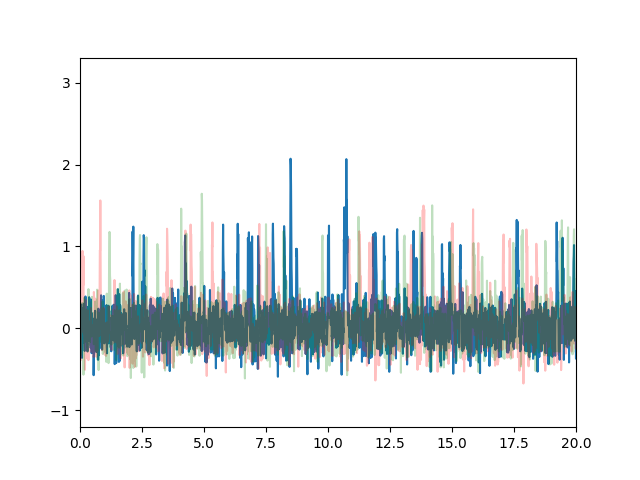

(0, 20)

In [8]:
fig, ax = plt.subplots()
ax.plot(
    all_activity.query('source == "cell_0"')['t'],
    all_activity.query('source == "cell_0"')['y'],
)

ax.plot(
    all_activity.query('source == "cell_1"')['t'],
    all_activity.query('source == "cell_1"')['y'],
    color = 'red',
    alpha = 0.25
)

ax.plot(
    all_activity.query('source == "cell_2"')['t'],
    all_activity.query('source == "cell_2"')['y'],
    color = 'green',
    alpha = 0.25
)

ax.set_xlim(0, 20)

<IPython.core.display.Javascript object>


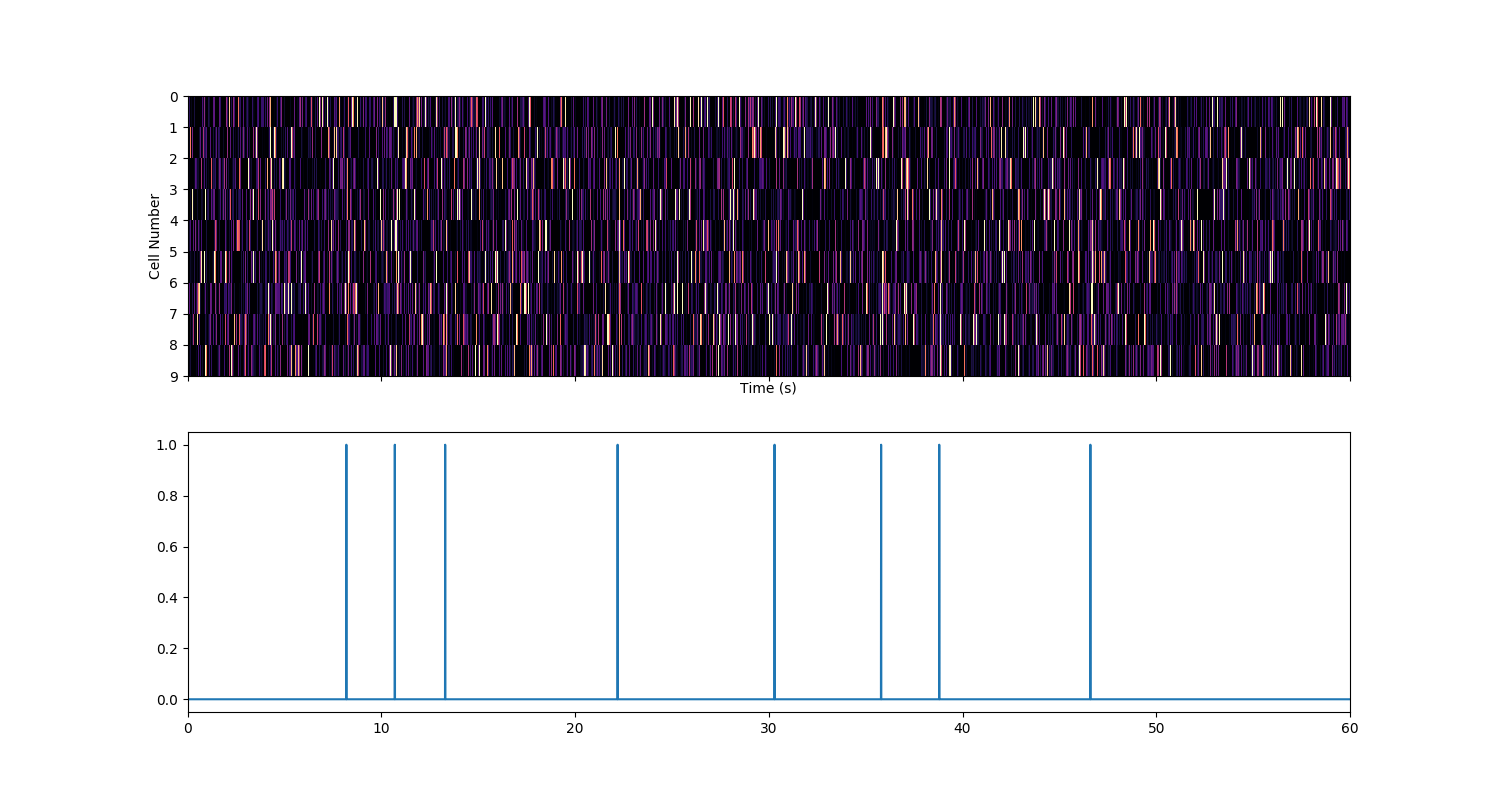

(0, 60)

In [11]:
fig, ax = plt.subplots(2,1,figsize=(15,8), sharex=True)

traces = all_activity.pivot(index='t',columns='source',values='y').reset_index()
heat_plot(traces,clim=[0,1],ax=ax[0], colorbar=False)

ax[1].plot(
    ts,
    y_events
)

ax[1].set_xlim(0, 60)

In [12]:
etr = []
shuffled_etr = []
for ii,cell in enumerate(cells.keys()):
    print('on cell {}'.format(cell), end = '\r')
    etr.append(event_triggered_response(
        all_activity.query('source == @cell'), 
        cell, 
        event_indices, 
        index_before = 50, 
        index_after = 50, 
    ))
    
    shuffled_etr.append(event_triggered_response(
        all_activity.query('source == @cell'), 
        cell, 
        random_event_indices, 
        index_before = 50, 
        index_after = 50, 
    ))
    
    etr[-1]['source'] = cell
    shuffled_etr[-1]['source'] = cell                   

etr = pd.concat(etr)
shuffled_etr = pd.concat(shuffled_etr)

In [13]:
etr

,relative_indices,value,event,event_number,source
0,-50,0.356350,820,0,cell_0
1,-49,-0.055082,820,0,cell_0
2,-48,-0.184936,820,0,cell_0
3,-47,0.343312,820,0,cell_0
4,-46,0.081323,820,0,cell_0
...,...,...,...,...,...
95,45,-0.078213,98810,99,cell_8
96,46,0.051986,98810,99,cell_8
97,47,-0.273936,98810,99,cell_8
98,48,0.000122,98810,99,cell_8


<IPython.core.display.Javascript object>


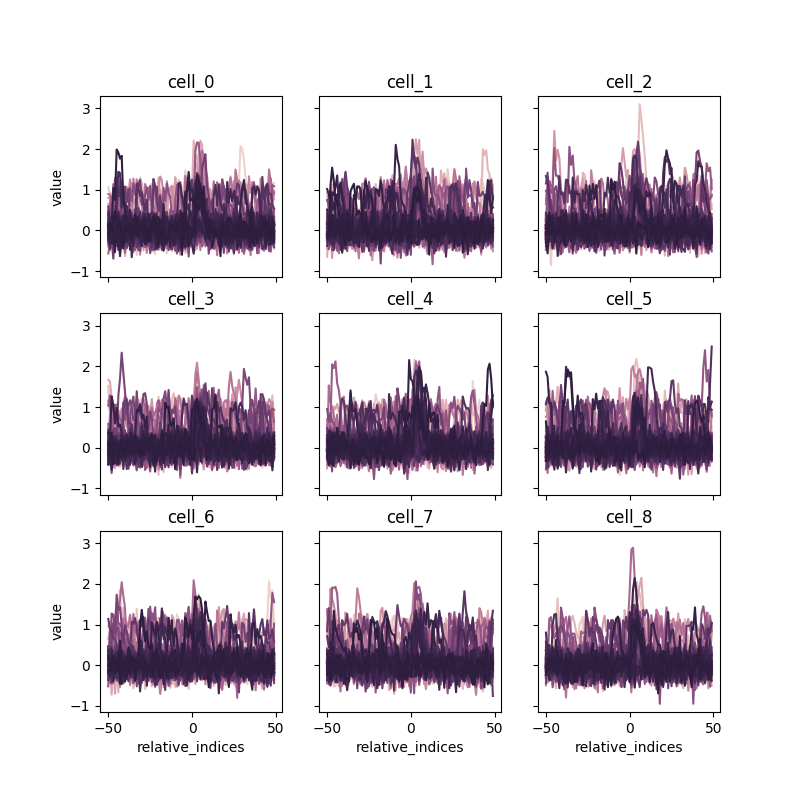

In [14]:
fig, ax = plt.subplots(3,3,figsize= (8,8), sharex=True, sharey=True)
for ii,cell in enumerate(cells.keys()):
    print('on cell {}'.format(cell), end = '\r')
    
    sns.lineplot(
        data = etr.query('source == @cell'),
        x = 'relative_indices',
        y = 'value',
        n_boot = 100,
        ax = ax.flatten()[ii],
#         color='blue',
        hue='event_number',
        legend=False
    )
    ax.flatten()[ii].set_title(cell)

In [15]:
def run_svm(cell_list, etr, shuffled_etr):
    X = (
        [etr.query('source in @cell_list and event_number == @event_number')['value'].values for event_number in etr['event_number'].unique()] + 
        [shuffled_etr.query('source in @cell_list and event_number == @event_number')['value'].values for event_number in shuffled_etr['event_number'].unique()]
    )
    y = [1 for event_number in etr['event_number'].unique()] + [0 for event_number in shuffled_etr['event_number'].unique()]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    res = {}
    res['confusion_matrix'] = confusion_matrix(y_test, y_pred)
    res['accuracy'] = accuracy_score(y_test, y_pred)
    res['precision'] = precision_score(y_test, y_pred)
    res['recall'] = recall_score(y_test, y_pred)
    
    return model, res

In [16]:
for cell in cells:
    print('on cell {}'.format(cell), end = '\r')
    
    cell_list = [cell]
    
    model, res = run_svm(cell_list, etr, shuffled_etr)
    
    cells[cell]['confusion_matrix'] = res['confusion_matrix']
    cells[cell]['accuracy'] = res['accuracy']
    cells[cell]['precision'] = res['precision']
    cells[cell]['recall'] = res['recall']


The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [17]:
results = pd.DataFrame(cells).transpose()
results

,reliability,jitter,noise_std,spontaneous_rate,confusion_matrix,accuracy,precision,recall
cell_0,0.6,0.01,0.2,1,"[[155, 4], [24, 15]]",0.858586,0.789474,0.384615
cell_1,0.6,0.01,0.2,1,"[[156, 3], [24, 15]]",0.863636,0.833333,0.384615
cell_2,0.6,0.01,0.2,1,"[[152, 7], [27, 12]]",0.828283,0.631579,0.307692
cell_3,0.6,0.01,0.2,1,"[[153, 6], [17, 22]]",0.883838,0.785714,0.564103
cell_4,0.6,0.01,0.2,1,"[[157, 2], [22, 17]]",0.878788,0.894737,0.435897
cell_5,0.6,0.01,0.2,1,"[[157, 2], [28, 11]]",0.848485,0.846154,0.282051
cell_6,0.6,0.01,0.2,1,"[[153, 6], [28, 11]]",0.828283,0.647059,0.282051
cell_7,0.6,0.01,0.2,1,"[[153, 6], [23, 16]]",0.853535,0.727273,0.410256
cell_8,0.6,0.01,0.2,1,"[[154, 5], [25, 14]]",0.848485,0.736842,0.358974


In [18]:
cell_list = [cell for cell in cells.keys()]
model, results = run_svm(cell_list, etr, shuffled_etr)
results

{'confusion_matrix': array([[159,   0],
        [ 10,  29]]),
 'accuracy': 0.9494949494949495,
 'precision': 1.0,
 'recall': 0.7435897435897436}

In [228]:
prediction_times = np.arange(0, 60, 0.1)
prediction_probs = np.zeros_like(prediction_times)
for prediction_index, prediction_time in tqdm(enumerate(prediction_times)):
    
    closest_ts_index = np.where(ts >= prediction_time)[0][0]
    etr_local = []
    for ii,cell in enumerate(cells.keys()):
        etr_local.append(event_triggered_response(
            df.query('source == @cell'), 
            cell, 
            [closest_ts_index], 
            index_before = 50, 
            index_after = 50, 
        ))
    etr_local = pd.concat(etr_local)
    prediction_probs[prediction_index] = model.predict_proba([etr_local['value'].fillna(0).values])[0][1]

600it [01:57,  5.12it/s]


<IPython.core.display.Javascript object>


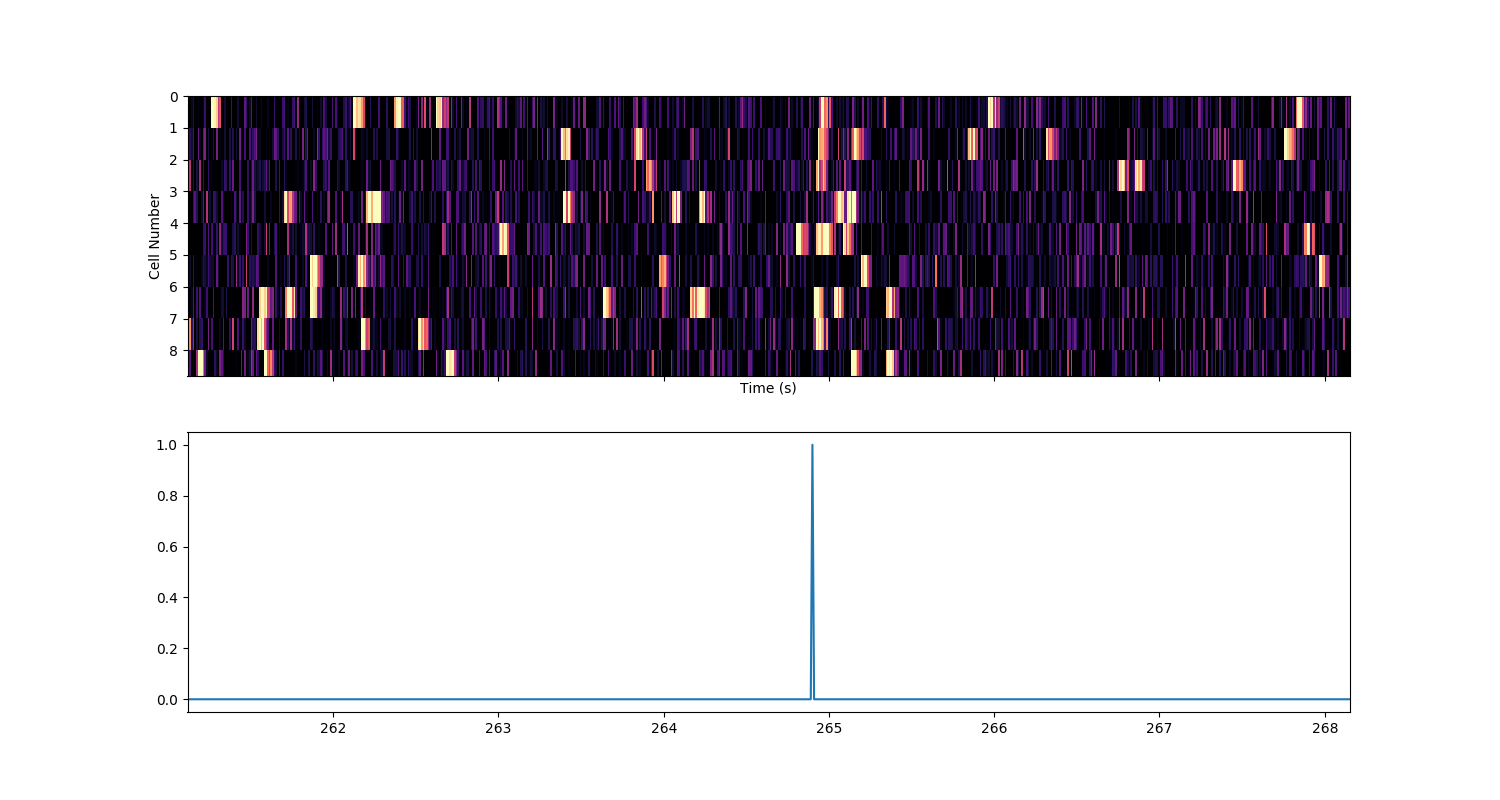

NameError: name 'prediction_times' is not defined

In [19]:
fig, ax = plt.subplots(2,1,figsize=(15,8), sharex=True)

traces = all_activity.pivot(index='t',columns='source',values='y').reset_index()
heat_plot(traces,clim=[0,1],ax=ax[0], colorbar=False)

ax[1].plot(
    ts,
    y_events
)

ax[1].plot(
    prediction_times,
    prediction_probs,
    marker = '.'
)
ax[1].set_xlim(0, 60)

In [191]:
from sklearn.decomposition import PCA

In [192]:
X = traces[all_activity['source'].unique()].T.values
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [193]:
np.shape(X)

(9, 100000)

In [194]:
print(pca.explained_variance_ratio_)

[0.2330284  0.22732718]


In [195]:
pca.explained_variance_

array([1193.47983653, 1164.28041148])

In [196]:
np.shape(pca.components_)

(2, 100000)

In [197]:
pca.components_

array([[ 4.50481860e-03,  2.30635360e-03, -1.75915899e-03, ...,
         1.23302268e-03,  1.57446886e-04, -1.68753687e-03],
       [ 3.63538887e-04,  2.02186217e-04,  3.00501630e-04, ...,
         4.97541304e-04, -3.89496849e-04,  4.72646970e-05]])

In [198]:
from sklearn.manifold import TSNE

In [199]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [200]:
X_embedded.shape

(9, 2)

In [201]:
X_embedded

array([[-244.36491 ,  225.82852 ],
       [ 290.15997 ,  230.9946  ],
       [  68.62389 ,   78.40857 ],
       [-215.963   , -303.0806  ],
       [-133.81223 ,  -43.715412],
       [   4.337657,  354.7416  ],
       [ 300.06085 ,  -83.84161 ],
       [-403.6508  ,  -27.036167],
       [  74.98348 , -253.441   ]], dtype=float32)

<IPython.core.display.Javascript object>


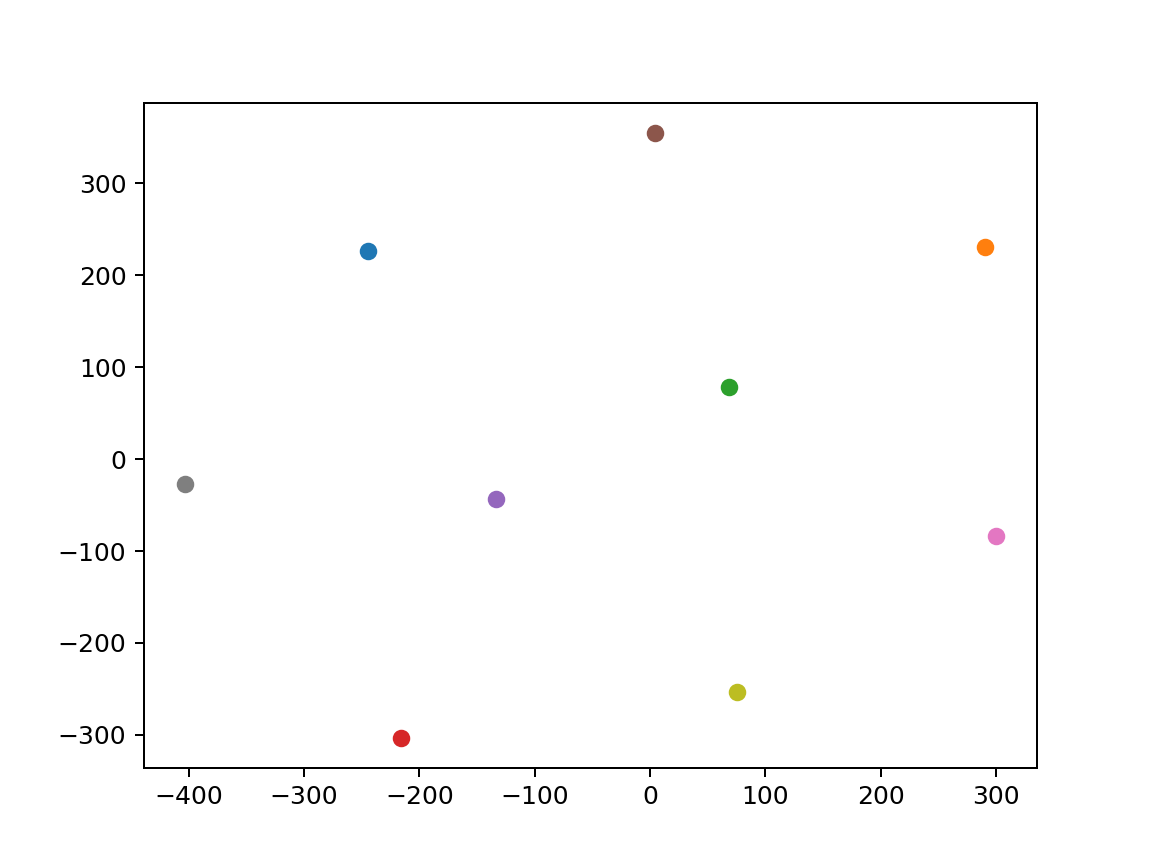

In [202]:
fig,ax = plt.subplots()
for point in X_embedded:
    ax.plot(point[0], point[1], 'o')

In [210]:
all_activity['source'].unique()

array(['cell_0', 'cell_1', 'cell_2', 'cell_3', 'cell_4', 'cell_5',
       'cell_6', 'cell_7', 'cell_8'], dtype=object)

<IPython.core.display.Javascript object>


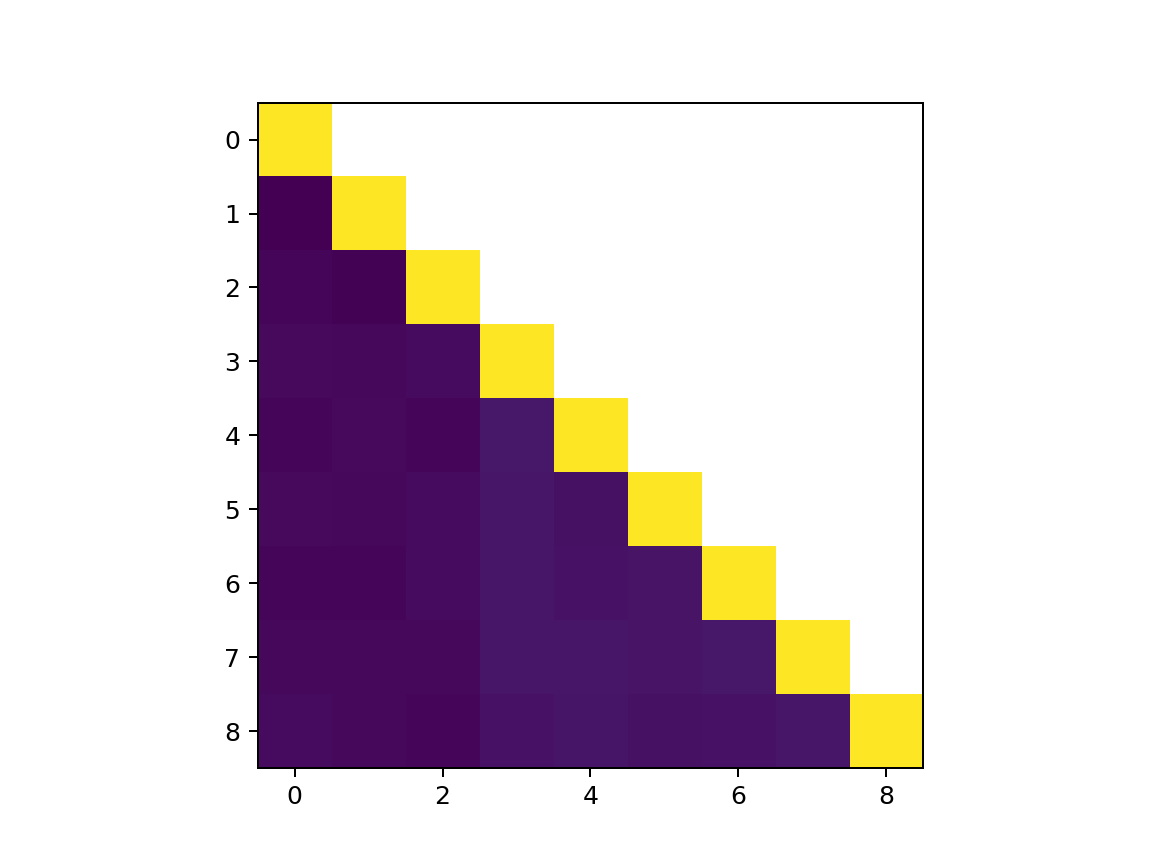

In [212]:
cell_ids = all_activity['source'].unique()
corr_matr = np.zeros((len(cell_ids),len(cell_ids)))*np.nan

for row, cell_1 in enumerate(cell_ids):
    for col, cell_2 in enumerate(cell_ids):
        if row>=col: #matrices are symmetric. Only calculate lower triangle
            corr_matr[row,col] = all_activity.query('source == @cell_1')['y'].corr(all_activity.query('source == @cell_2')['y'])

fig, ax = plt.subplots()
ax.imshow(corr_matr)

In [215]:
all_activity.pivot(index='t',columns='source',values='y').corr()

source,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8
source,,,,,,,,,
cell_0,1.000000,0.023659,0.037877,0.050323,0.041265,0.049413,0.041947,0.044168,0.050886
cell_1,0.023659,1.000000,0.028560,0.044637,0.047279,0.044784,0.036871,0.046380,0.044914
cell_2,0.037877,0.028560,1.000000,0.052527,0.039761,0.052843,0.053048,0.043488,0.037322
cell_3,0.050323,0.044637,0.052527,1.000000,0.086432,0.081303,0.081056,0.084375,0.071625
cell_4,0.041265,0.047279,0.039761,0.086432,1.000000,0.069310,0.070538,0.082359,0.078297
cell_5,0.049413,0.044784,0.052843,0.081303,0.069310,1.000000,0.074739,0.076779,0.067420
cell_6,0.041947,0.036871,0.053048,0.081056,0.070538,0.074739,1.000000,0.087713,0.072715
cell_7,0.044168,0.046380,0.043488,0.084375,0.082359,0.076779,0.087713,1.000000,0.082531
cell_8,0.050886,0.044914,0.037322,0.071625,0.078297,0.067420,0.072715,0.082531,1.000000


<IPython.core.display.Javascript object>


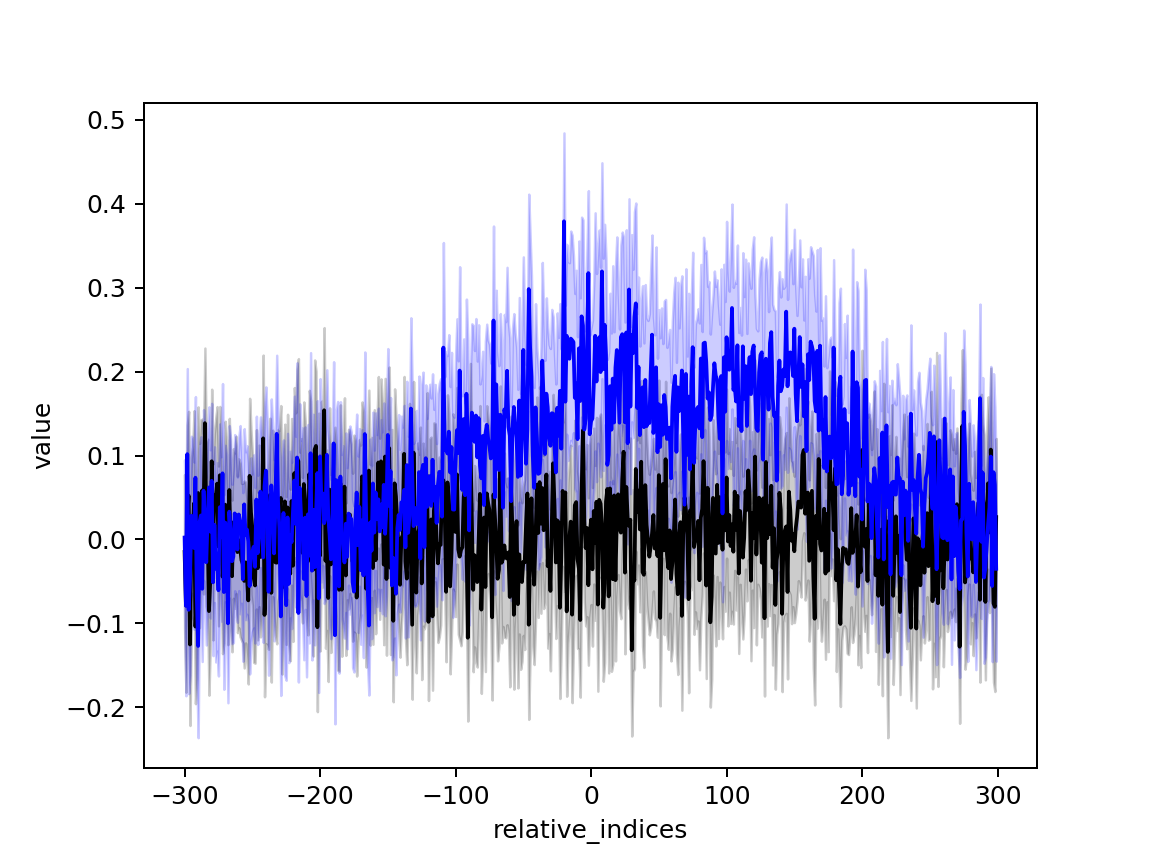

In [249]:
fig, ax = plt.subplots()
sns.lineplot(
    data = shuffled_etr,
    x = 'relative_indices',
    y = 'value',
    n_boot = 1000,
    ax = ax,
    color='black'
)

sns.lineplot(
    data = etr,
    x = 'relative_indices',
    y = 'value',
    n_boot = 1000,
    ax = ax,
    color='blue'
)

In [ ]:
for cell in c

In [250]:
training_event_numbers = np.random.choice(np.arange(n_events), size = int(0.8*n_events), replace=False)
training_event_numbers
testing_event_numbers = list(set(np.arange(n_events)) - set(training_event_numbers))


clf = svm.SVC()
clf.fit(X, y)

SVC()

In [251]:
event_number = np.random.choice(testing_event_numbers)
clf.predict([etr.query('event_number == @event_number')['value'].values])

array([1])

In [252]:
X_test = [etr.query('event_number == @event_number')['value'].values for event_number in testing_event_numbers]
y_test = clf.predict(X_test)
y_test.mean()

1.0

In [253]:
X_test_shuffle = [shuffled_etr.query('event_number == @event_number')['value'].values for event_number in testing_event_numbers]
y_test_shuffle = clf.predict(X_test_shuffle)
y_test_shuffle.mean()

0.0

In [ ]:
## up next:
* make a routine to calculate accuracy/precision/recall for each cell individually
* make a routine to calculate accuracy/precision/recall for any combination of cells
* define decodability for all combinations of cells
* make a new set of cells, all of which have reduced reliability
* show that no individual cell can be decoded with accuracy higher than its own reliability
* make X vectors that are combinations of cells
* show that the population provides more information than any cell alone
* maybe add some spontaneous activity to the traces?
* maybe vary the event magnitudes?